# Setting

In [0]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"young917","key":"38554d8ee11a16273014fb43b7fdc0a1"}'}

In [0]:
%ls -1ha kaggle.json

kaggle.json


In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json
# 본인이 참가한 모든 대회 보기 
!kaggle competitions list

ref                                               deadline             category            reward  teamCount  userHasEntered  
------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                                  2030-01-01 00:00:00  Getting Started  Knowledge       3176           False  
titanic                                           2030-01-01 00:00:00  Getting Started  Knowledge      23422           False  
house-prices-advanced-regression-techniques       2030-01-01 00:00:00  Getting Started  Knowledge       5386            True  
connectx                                          2030-01-01 00:00:00  Getting Started  Knowledge        388           False  
nlp-getting-started                               2030-01-01 00:00:00  Getting Started      Kudos       1711            True  
competitive-data-science-predict-future-sales     2020-12-31 23:59:00  Playground           Kudos       7191   

In [0]:
!kaggle competitions download -c nlp-getting-started

  0% 0.00/22.2k [00:00<?, ?B/s]
100% 22.2k/22.2k [00:00<00:00, 8.16MB/s]
  0% 0.00/965k [00:00<?, ?B/s]
100% 965k/965k [00:00<00:00, 63.1MB/s]
  0% 0.00/411k [00:00<?, ?B/s]
100% 411k/411k [00:00<00:00, 129MB/s]


In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


# **Data Load**

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 200)
import spacy

plt.rcParams["figure.figsize"] = (15,5)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


In [0]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
print(test)

         id  ...                                                                                                                                         text
0     0      ...  Just happened a terrible car crash                                                                                                         
1     2      ...  Heard about #earthquake is different cities, stay safe everyone.                                                                           
2     3      ...  there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all                                           
3     9      ...  Apocalypse lighting. #Spokane #wildfires                                                                                                   
4     11     ...  Typhoon Soudelor kills 28 in China and Taiwan                                                                                              
...   ..     ...                                    

#### Data Cleaning

In [0]:
from nltk.corpus import stopwords
from nltk.util import ngrams
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub

In [0]:
import nltk

nltk.download('stopwords')
stop=set(stopwords.words('english'))

punctuation = string.punctuation

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


##### train과 test set에서 URL, html, 구두점을 삭제한다.

In [0]:
df=pd.concat([train,test])
df.shape

(10876, 5)

In [0]:
import re

# remove http
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

df['text']=df['text'].apply(lambda x : remove_URL(x))

# remove HTML tags
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
df['text']=df['text'].apply(lambda x : remove_html(x))

# remove punctuations
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)
df['text']=df['text'].apply(lambda x : remove_punct(x))

## **Model**

In [0]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [0]:
!pip install sentencepiece

     |████████████████████████████████| 1.1MB 2.8MB/s 


#### Encoding

In [0]:
# text -> tokens with padding
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [0]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    drop_out = tf.keras.layers.Dropout(0.2)(clf_output)
    out = Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.01))(drop_out)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [0]:
%%time
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

CPU times: user 29.9 s, sys: 5.52 s, total: 35.4 s
Wall time: 42.3 s


In [0]:
import tokenization

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [0]:
train = df[:-3263]
test = df[-3263:]

In [0]:
train_input = bert_encode(train.text.values, tokenizer, max_len=160)
test_input = bert_encode(test.text.values, tokenizer, max_len=160)
train_labels = train.target.values

#### Build Model

In [0]:
model = build_model(bert_layer, max_len=160)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [0]:
%%time
train_history = model.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=15,
    batch_size=8
)

Epoch 1/15
762/762 [==============================] - 401s 526ms/step - loss: 0.4969 - accuracy: 0.7837 - val_loss: 0.4273 - val_accuracy: 0.8313
Epoch 2/15
762/762 [==============================] - 398s 522ms/step - loss: 0.3786 - accuracy: 0.8468 - val_loss: 0.4185 - val_accuracy: 0.8293
Epoch 3/15
762/762 [==============================] - 398s 522ms/step - loss: 0.2884 - accuracy: 0.8924 - val_loss: 0.4280 - val_accuracy: 0.8299
Epoch 4/15
762/762 [==============================] - 398s 522ms/step - loss: 0.2080 - accuracy: 0.9284 - val_loss: 0.4829 - val_accuracy: 0.8332
Epoch 5/15
762/762 [==============================] - 398s 522ms/step - loss: 0.1406 - accuracy: 0.9596 - val_loss: 0.5424 - val_accuracy: 0.8247
Epoch 6/15
762/762 [==============================] - 398s 522ms/step - loss: 0.1200 - accuracy: 0.9650 - val_loss: 0.5835 - val_accuracy: 0.8221
Epoch 7/15
762/762 [==============================] - 398s 522ms/step - loss: 0.0985 - accuracy: 0.9727 - val_loss: 0.6457 -

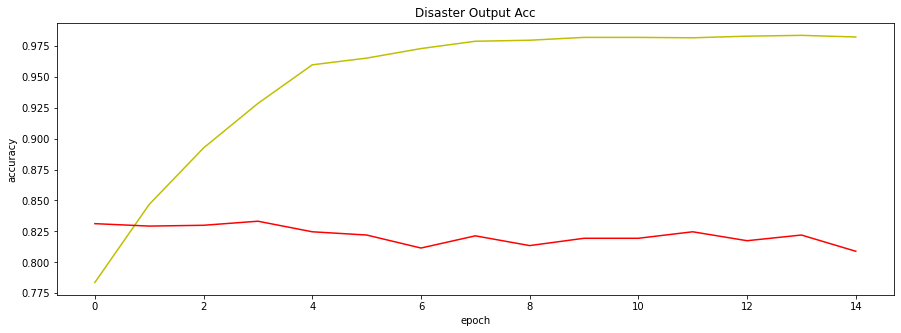

In [0]:
import matplotlib.pyplot as plt

fig = plt.figure()

plt.plot(train_history.history['accuracy'], 'y', label='train accuracy')
plt.plot(train_history.history['val_accuracy'], 'r', label='val accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title("Disaster Output Acc")

plt.show()

In [0]:
model.save('Bertmodel.h5')

In [0]:
cp './Bertmodel.h5' '/content/gdrive/My Drive/Data Mining Project/Bertmodel.h5'

## Submission

In [0]:
submission=pd.read_csv('./sample_submission.csv')

In [0]:
test_pred = model.predict(test_input)
submission['target'] = test_pred.round().astype(int)
submission.to_csv('Bert_submission.csv', index=False)

In [0]:
submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [0]:
!cp './Bert_submission.csv' '/content/gdrive/My Drive/Data Mining Project/Bert_submission.csv'

In [0]:
submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,0
3259,10865,1
3260,10868,1
3261,10874,1
